In [7]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.distributions as dist

import pyro
import pyro.distributions as dist
import pyro.infer.mcmc as mcmc
from pyro.infer.mcmc import MCMC
from pyro.distributions import Distribution

from elliptic_files.MetropolisHastings import MetropolisHastingsSampler
from elliptic_files.FEM_Solver import RootFinder,FEMSolver
from elliptic_files.utilities import *

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



np.random.seed(42)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Tiaming Experiment 3

$$-\frac{d}{dx}(e^{k(x,\theta)}\frac{du(x)}{dx}) = 4x, \quad x\in (0,1),\theta \in [-1,1]$$
$$u(0) = 0, u(1)=2$$

where $k(x,\theta)$ has the following form:
 
$$  
k(x,\theta) =exp \left( \sum_{n=1}^{2} \sqrt a_{n} \theta_{n} b_{n}(x)  \right)
$$

where $a_{n} = \frac{8}{w_{n}^{2} + 16}$ and $b_{n} = A_{n}\left(  \text{sin}(w_{n}x) + \frac{w_{n}}{4} \text{cos}(w_{n}x) \right)$, $w_{n}$ is the $n_{th}$ solution of the equation $\text{tan} (w_{n}) = \frac{8w_{n}}{w_{n}^{2}-16}$ and $A_{n}$ is a constant of normalization which makes $\|b_{n}\| = 1$.

## Computing Roots

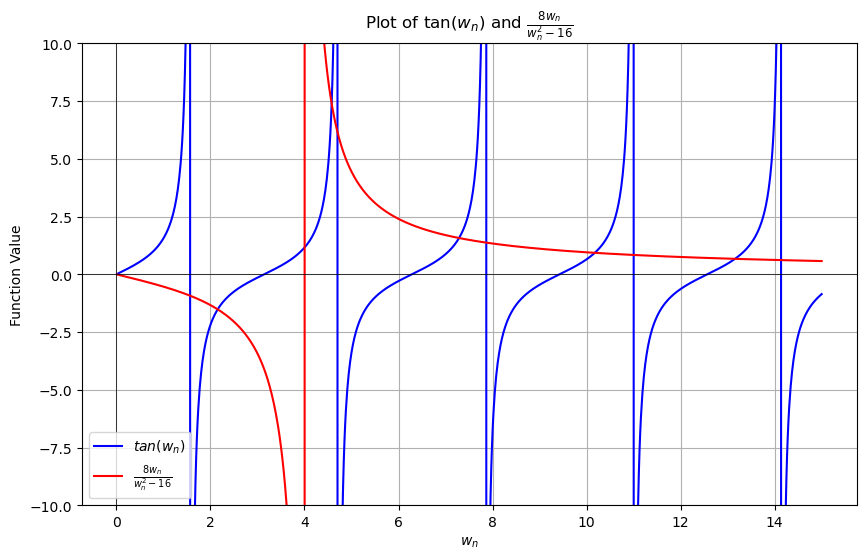

In [14]:

# Define the functions
def tan_func(wn):
    return np.tan(wn)

def rational_func(wn):
    return (8 * wn) / (wn**2 - 16)

# Create a range of values for wn avoiding the singularities of tan(wn)
wn_values = np.linspace(0, 15, 1000)

# To avoid the singularities at multiples of pi/2, let's exclude those values
wn_values = wn_values[(wn_values % (np.pi/2)) != 0]

# Evaluate the functions
tan_values = tan_func(wn_values)
rational_values = rational_func(wn_values)

# Plot the functions
plt.figure(figsize=(10, 6))
plt.plot(wn_values, tan_values, label=r'$tan(w_n)$', color='blue')
plt.plot(wn_values, rational_values, label=r'$\frac{8w_n}{w_n^2 - 16}$', color='red')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)

# Add labels and title
plt.title(r'Plot of $\tan(w_n)$ and $\frac{8w_n}{w_n^2 - 16}$')
plt.xlabel(r'$w_n$')
plt.ylabel('Function Value')
plt.legend()
plt.ylim(-10, 10)  # Limit the y-axis to focus on intersections
plt.grid(True)
plt.show()


In [15]:
# Example Usage
lam = 1 / 4
M = 2

finder = RootFinder(lam, M)
roots = finder.find_roots()

print("Roots:", roots)

Roots: [2.15374797 4.57785946]


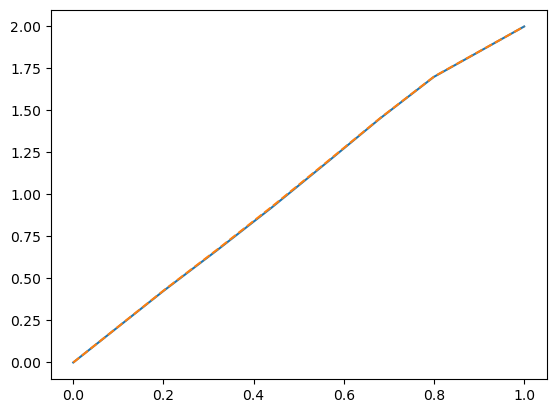

In [16]:
theta_th=np.array([0.098, 0.430])

dy = 6
x = [0] + list(np.linspace(0.2,0.8,dy)) + [1]

y_tia = [0,4.257174963573532311e-01,6.704236569661589096e-01,9.221336565815004827e-01,1.185151034069622744e+00,
         1.451691910058344304e+00,1.700335624196542383e+00,2]

solver = FEMSolver(theta_th, vert=10)
solver.solve()

y = solver.eval_at_points(np.array(x).reshape(-1, 1))


plt.plot(x,y_tia)
plt.plot(x,y,linestyle = "--")

# Moreau Yosida

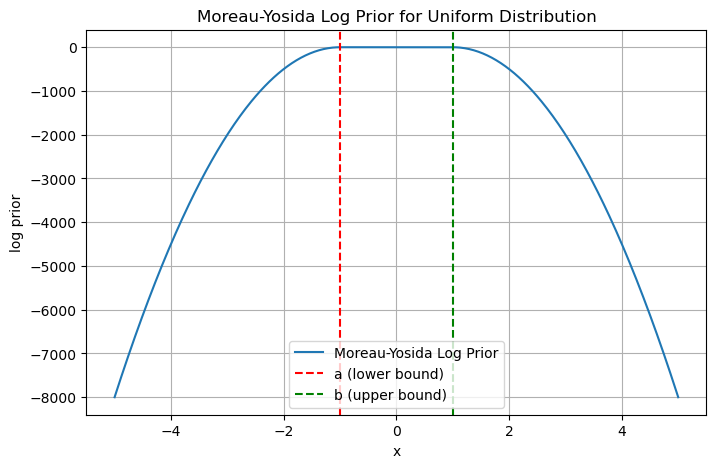

In [17]:

# Define the Moreau-Yosida log prior function
def log_prior_moreau_yosida(x, a, b, lam):
    log_prior = np.zeros_like(x)
    log_prior[x < a] = -(1 / (2 * lam)) * (x[x < a] - a)**2
    log_prior[x > b] = -(1 / (2 * lam)) * (x[x > b] - b)**2
    return log_prior

def log_uniform_moreau_yosida(x, lam):
    # Apply the Moreau-Yosida regularization term to the uniform distribution
    # Assuming x is the input parameter, and lam is the regularization parameter
    regularization_term =-(np.maximum(np.abs(x)-1, 0) ** 2) / (2 * lam)
    scaling_term = (2 + np.sqrt(2 * np.pi * lam)) ** (-1)
    
    return regularization_term +  np.log(scaling_term)

# Parameters for the uniform distribution
a = -1.0  # Lower bound
b = 1.0  # Upper bound
lam = 1e-3  # Regularization parameter (lambda)

# Generate a range of x values
x_vals = np.linspace(-5, 5, 500)

# Compute the log prior values
log_prior_vals = log_uniform_moreau_yosida(x_vals, lam)

# Plot the log prior
plt.figure(figsize=(8, 5))
plt.plot(x_vals, log_prior_vals, label='Moreau-Yosida Log Prior')
plt.axvline(a, color='r', linestyle='--', label='a (lower bound)')
plt.axvline(b, color='g', linestyle='--', label='b (upper bound)')
plt.xlabel('x')
plt.ylabel('log prior')
plt.title('Moreau-Yosida Log Prior for Uniform Distribution')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
class MoreauYosidaPrior(Distribution):
    def __init__(self, lam, batch_shape=torch.Size([]), device='cpu'):
        super().__init__()
        self.device = device
        self.batch_shape = torch.Size(batch_shape)  # Ensure batch_shape is a torch.Size object
        self.lam = torch.tensor(lam, dtype=torch.float32, device=self.device)


    @property
    def event_shape(self):
        """The event shape for this distribution is 1-dimensional."""
        return torch.Size([1])

    @property
    def support(self):
        """The support of the distribution is the whole real line."""
        return dist.constraints.real

    def log_prob(self, x):
        """Calculate the log probability of x under the Moreau-Yosida prior."""
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32, device=self.device)

        # Calculate the regularization term
        regularization_term = -(torch.clamp(torch.abs(x) - 1, min=0) ** 2) / (2 * self.lam)
        log_prob = regularization_term - torch.log(2 + torch.sqrt(2 * torch.pi * self.lam))

        return log_prob

    def sample(self, sample_shape=torch.Size()):
        """Sample from the Moreau-Yosida prior using importance sampling."""
        sample_shape = torch.Size(sample_shape)  # Ensure sample_shape is a torch.Size object
        total_shape = self.batch_shape + sample_shape  # Concatenate batch_shape with sample_shape

        # Proposal distribution with heavier tails (e.g., Normal distribution)
        proposal_dist = dist.Normal(loc=0.0, scale=2.0)  # Wider scale for more tail coverage
        proposals = proposal_dist.sample(total_shape).to(self.device)

        # Calculate log probabilities for the proposals under the Moreau-Yosida prior
        log_prob_samples = self.log_prob(proposals)

        # Calculate log probability of the proposal distribution
        log_prob_proposal = proposal_dist.log_prob(proposals)

        # Calculate weights for importance sampling
        weights = torch.exp(log_prob_samples - log_prob_proposal)

        # Clamp weights to avoid negative entries
        weights = torch.clamp(weights, min=0)

        # Normalize weights
        weights_sum = torch.sum(weights)
        if weights_sum > 0:  # Prevent division by zero
            weights /= weights_sum
        else:
            # If all weights are zero, return uniformly sampled values
            return proposals

        # Resample according to weights (multinomial resampling)
        idx = torch.multinomial(weights, total_shape[0], replacement=True)
        resampled_proposals = proposals[idx]

        return resampled_proposals

    def expand(self, batch_shape, _instance=None):
        """Expand the distribution to a new batch shape."""
        return MoreauYosidaPrior(self.lam, batch_shape, self.device)

# Example usage
lam = 0.001
my_prior = MoreauYosidaPrior(lam)

# Draw samples
num_samples = 10000
samples = my_prior.sample((num_samples,))
# Output some samples
print(f"Samples: {samples[:5]}")

Samples: tensor([ 0.5988,  0.2921, -0.4168, -0.3925,  0.8086])


(-3.0, 3.0)

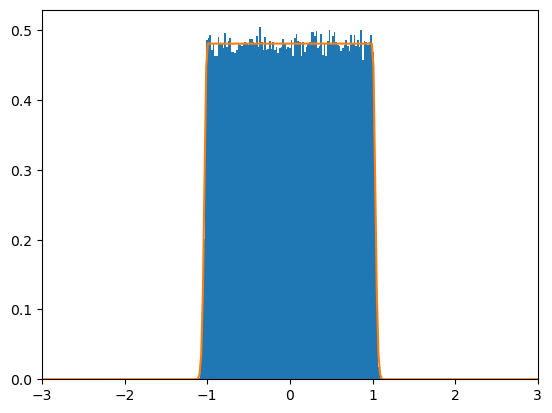

In [19]:

lam = 0.001
my_prior = MoreauYosidaPrior(lam)

# Draw samples
num_samples = 1000000
samples = pyro.sample("theta", my_prior.expand([num_samples]))

def log_uniform_moreau_yosida(x, lam):
    # Apply the Moreau-Yosida regularization term to the uniform distribution
    # Assuming x is the input parameter, and lam is the regularization parameter
    regularization_term =-(np.maximum(np.abs(x)-1, 0) ** 2) / (2 * lam)
    scaling_term = (2 + np.sqrt(2 * np.pi * lam)) ** (-1)
    
    return regularization_term +  np.log(scaling_term)

# Generate a range of x values
x_vals = np.linspace(-5, 5, 500)

plt.hist(samples,density=True, bins=x_vals)
plt.plot(x_vals,np.exp(log_uniform_moreau_yosida(x_vals,lam)))
plt.xlim(-3,3)

# Samples from FEM using Moreau Yosida

In [20]:
theta_th=np.array([0.098, 0.430])
var = [1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100]
obs = [10,25,50,100]
vertices = [50]

# for ob in obs:
#     for vr in var:
#         st = np.sqrt(vr)
#         obs_points, obs_sol = generate_noisy_obs(ob, theta_t=theta_th, mean=0, std=st,vert=200)

#         for hvert in vertices:

#             sampler = MetropolisHastingsSampler(obs_points, obs_sol, sig = st,numerical = True, roots=roots, vert=hvert)

#             samp_num,dt_tracker_num = sampler.run_sampler(n_chains=1005000)

#             np.save(f'./Models/FEM_h{hvert}_var{vr}_obs{ob}.npy', samp_num)

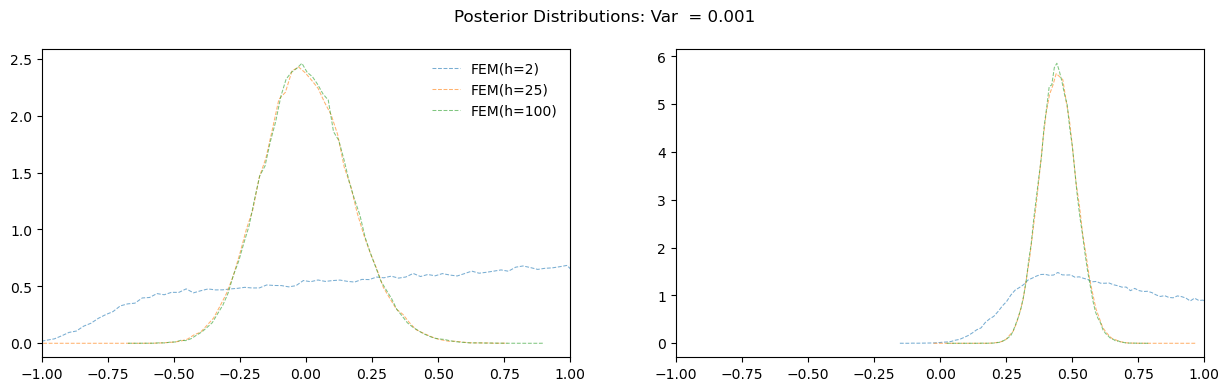

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4),sharex=True)
bins =80
var = [1e-3]
res = [2,25,100]

fig.suptitle(f"Posterior Distributions: Var  = {var[0]}")
for i,h in  enumerate(res):
    sample = np.load(f'./Models/FEM_h{h}_var{1e-3}_obs{10}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM(h={h})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM(h={h})")
    
axs[0].set_xlim(-1,1),axs[1].set_xlim(-1,1)
axs[0].legend(frameon = False)

In [11]:
grid  =25
parameter  = np.linspace(0,0.2,grid)

X, Y = np.meshgrid(parameter, parameter)
results = np.zeros((grid, grid, len(res)))

solver = FEMSolver(np.zeros(2), vert = 1000)

# Main loop over parameter space
for i, par1 in enumerate(parameter):
    for j, par2 in enumerate(parameter):
        pr = np.array([par1, par2])

        # Update the solver with new parameter values
        solver.theta = pr  # Update the parameter vector
        solver.uh = None  # Reset the FEM solution
        solver.solve()

        # Get FEM solution arrays
        x_FEM, y_FEM = solver.solution_array()
        x_FEM, y_FEM = x_FEM[:, 0].reshape(-1, 1), y_FEM.reshape(-1, 1)

        # Loop over observation sizes N
        for z, h in enumerate(res):
            solver2 = FEMSolver(np.zeros(2), vert = h)

            solver2.theta = pr  # Update the parameter vector
            solver2.uh = None  # Reset the FEM solution
            solver2.solve()

            y2 = solver2.eval_at_points(x_FEM).reshape(-1, 1)

            # Compute the maximum error between FEM and surrogate
            max_error = np.max(np.abs(y_FEM - y2))
            results[i, j, z] = max_error
            del solver2


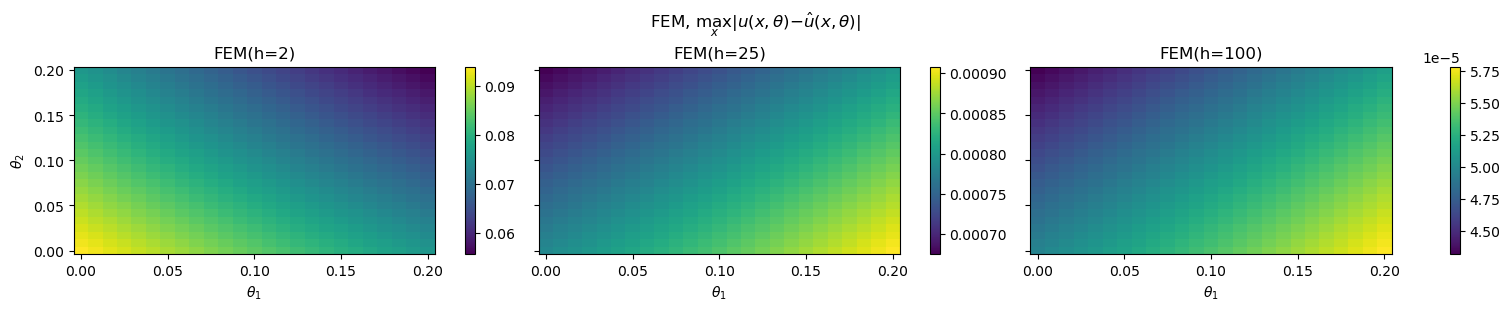

In [12]:
fig, axs = plt.subplots(1, len(res), figsize=(15, 3), layout="constrained", sharey=True)
fig.suptitle(fr"FEM, $\max_{{x}} | u(x, \theta) - \hat{{u}}(x, \theta)|$", fontsize=12)

for z, key in enumerate(res):
    Z = results[:, :, z]  # Extract the results for current N
    # Plot the heatmap for each N
    pcm = axs[z].pcolormesh(X, Y, Z, shading='auto')
    axs[z].set_xlabel(r"$\theta_1$")
    axs[z].set_title(f"FEM(h={key})")
    plt.colorbar(pcm, ax=axs[z])

axs[0].set_ylabel(r"$\theta_2$")  # Set common y-axis label
plt.show()

# Delayed Acceptance MH

In [19]:
class DAHM:
    """
    A class to perform Metropolis-Hastings sampling for parameter inference.
    It can use a neural network surrogate model or a numerical solver for likelihood evaluation.
    """

    def __init__(self, x, y, vert1=2, vert2 = 100, nparam=2, sig=1.0, dt_init=0.5, 
                  lam = 1 /4, M = 2, reg=1e-3, device='cpu'):
        """
        Initialize the Metropolis-Hastings sampler.
        
        Args:
            surrogate: Surrogate neural network model.
            x: Input data (independent variables).
            y: Observed data (dependent variables).
            sig: Standard deviation of the noise in the observations (default 1.0).
            dt_init: Initial step size for the proposal distribution (default 0.5).
            numerical: Whether to use a numerical solver instead of the surrogate model (default False).
            roots: Roots for FEM solver, used if numerical=True (optional).
            vert: Vertices for FEM solver, used if numerical=True (optional).
            lam: Regularization parameter for the Moreau-Yosida regularization.
            device: Device to run the model (default 'cpu').
        """
        self.device = device

        self.x = torch.tensor(x, dtype=torch.float32, device=self.device)
        self.y = torch.tensor(y, dtype=torch.float32, device=self.device)
        self.sig = torch.tensor(sig, dtype=torch.float32, device=self.device)
        self.dt = torch.tensor(dt_init, dtype=torch.float32, device=self.device)
        self.reg = torch.tensor(reg,dtype=torch.float32, device=self.device)  # Regularization parameter
        self.lam = lam
        self.M = M

        self.nparam = nparam
        self.vert1 = vert1
        self.vert2 = vert2


        # Initialize the FEMSolver once, if numerical solver is used
        self.solver1 = FEMSolver(np.zeros(self.nparam), self.lam,self.M, vert=self.vert1)
        self.solver2 = FEMSolver(np.zeros(self.nparam), self.lam,self.M, vert=self.vert2)


        self.scaling_term = 1 / (2 + torch.sqrt(2 * torch.pi * self.reg)).to(self.device)  # Calculate once


    def log_prior_alpha(self, theta):
        """
        Log prior with Moreau-Yosida regularization for the uniform distribution between -1 and 1.
        """
        # Regularization term for all theta values
        regularization_term = -(torch.clamp(torch.abs(theta) - 1, min=0) ** 2) / (2 * self.reg)
        return torch.sum(regularization_term + torch.log(self.scaling_term))

    def proposals(self, alpha):
        """
        Generates proposals for the next step in the Metropolis-Hastings algorithm using a normal distribution.
        
        Args:
            alpha: Current parameter values.
        
        Returns:
            New proposed parameter values.
        """
        # Generate normal proposals
        proposal = alpha + torch.normal(mean=torch.zeros_like(alpha), std=self.dt).to(self.device)
        
        return proposal

    def log_likelihood(self,solver,pr):

        """
        Evaluates the log-likelihood given the surrogate model or numerical solver.
        
        Args:
            pr: Current parameters.
        
        Returns:
            Log-likelihood value.
        """
        solver.theta = pr.cpu().numpy()  # Convert to numpy for FEM solver
        solver.solve()
        surg = solver.eval_at_points(self.x.cpu().numpy()).reshape(-1, 1)

        surg = torch.tensor(surg, device=self.device)

        return -0.5 * torch.sum(((self.y - surg) ** 2) / (self.sig ** 2))

        
    def log_posterior(self, solver,pr):
        """
        Evaluates the log-posterior using the surrogate model.
        
        Args:
            pr: Current parameters.
        
        Returns:
            Log-posterior value.
        """
        return self.log_likelihood(solver,pr) + self.log_prior_alpha(pr)

    def run_sampler(self, n_chains, verbose=True):
        """
        Run the Metropolis-Hastings sampling process sequentially.
        
        Args:
            n_chains: Number of steps in the chain.
            verbose: Whether to print progress (default True).
        
        Returns:
            alpha_samp: Sampled parameter values.
            dt_tracker: Step size progression over the chain.
        """
        # Initialize the parameters randomly within the prior range
        alpha = torch.empty(self.nparam, device=self.device).uniform_(-1, 1)
        alpha_samp = torch.zeros((n_chains, self.nparam), device=self.device)
        dt_tracker = torch.zeros(n_chains, device=self.device)
        acceptance_rate = 0

        for i in range(n_chains):
            # Propose new alpha values
            alpha_proposal = self.proposals(alpha)
            
            # Compute the current log-posterior
            log_posterior_current = self.log_posterior(self.solver1,alpha)
            log_posterior_proposal = self.log_posterior(self.solver1,alpha_proposal)

            # Compute the acceptance ratio
            a = torch.clamp(torch.exp(log_posterior_proposal - log_posterior_current), max=1.0)

            # Accept or reject the proposal
            if torch.rand(1, device=self.device) < a:
                log_posterior_current2 = self.log_posterior(self.solver2,alpha)
                log_posterior_proposal2 = self.log_posterior(self.solver2,alpha_proposal)

                # Compute the acceptance ratio
                a = torch.clamp(torch.exp(log_posterior_proposal2 - (log_posterior_current2 + a)), max=1.0)

                if torch.rand(1, device=self.device) < a:
                    alpha = alpha_proposal
                    acceptance_rate += 1

            # Store the current sample and step size
            alpha_samp[i] = alpha
            dt_tracker[i] = self.dt

            # Adaptive step size adjustment 
            self.dt += self.dt * (a - 0.234) / (i + 1)

            del log_posterior_current, log_posterior_proposal, alpha_proposal
            if self.device != "cpu":
                torch.cuda.empty_cache()

            # Print progress every 10% of the steps
            if verbose and i % (n_chains // 10) == 0:
                print(f"Iteration {i}, Acceptance Rate: {acceptance_rate / (i + 1):.3f}, Step Size: {self.dt:.4f}")

        if verbose:
            print(f"Final Acceptance Rate: {acceptance_rate / n_chains:.3f}")

        return alpha_samp.detach().cpu().numpy(), dt_tracker.detach().cpu().numpy()


In [21]:
theta_th=np.array([0.098, 0.430])

st = np.sqrt(1e-3)
obs_points, obs_sol = generate_noisy_obs(10, theta_t=theta_th, mean=0, std=st,vert=200)

dahm  = DAHM(obs_points, obs_sol)
samples,dt = dahm.run_sampler(100000)

Iteration 0, Acceptance Rate: 0.000, Step Size: 0.5786


Exception ignored in: <function LinearProblem.__del__ at 0x7fbc253be660>
Traceback (most recent call last):
  File "/home/s2113174/anaconda3/envs/fenicsx-env/lib/python3.12/site-packages/dolfinx/fem/petsc.py", line 805, in __del__
    self._solver.destroy()
    ^^^^^^^^^^^^
AttributeError: 'LinearProblem' object has no attribute '_solver'
Exception ignored in: <function LinearProblem.__del__ at 0x7fbc253be660>
Traceback (most recent call last):
  File "/home/s2113174/anaconda3/envs/fenicsx-env/lib/python3.12/site-packages/dolfinx/fem/petsc.py", line 805, in __del__
    self._solver.destroy()
    ^^^^^^^^^^^^
AttributeError: 'LinearProblem' object has no attribute '_solver'


Iteration 10000, Acceptance Rate: 0.221, Step Size: 0.5832
Iteration 20000, Acceptance Rate: 0.224, Step Size: 0.5897
Iteration 30000, Acceptance Rate: 0.224, Step Size: 0.5932
Iteration 40000, Acceptance Rate: 0.223, Step Size: 0.5944
Iteration 50000, Acceptance Rate: 0.223, Step Size: 0.5954
Iteration 60000, Acceptance Rate: 0.223, Step Size: 0.5968
Iteration 70000, Acceptance Rate: 0.223, Step Size: 0.5981
Iteration 80000, Acceptance Rate: 0.222, Step Size: 0.5986
Iteration 90000, Acceptance Rate: 0.222, Step Size: 0.5991
Final Acceptance Rate: 0.222


# Pyro sampler for FEM

In [23]:

# # Define the model using a coarse FEM solver
# def model(surrogate_fem_solver,synthetic_data, points,noise_std,vert):
#     # Prior for the parameters theta (assuming 2 parameters)
#     theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))

#     # Use a coarse mesh FEM solver as the surrogate model
#     surrogate_fem_solver.theta = theta.detach().numpy()  # Update the parameter vector

#     surrogate_fem_solver.uh = None

#     surrogate_fem_solver.solve()

#     # Get model predictions at the given points
#     model_predictions = torch.Tensor(surrogate_fem_solver.eval_at_points(points))

#     # Likelihood: Gaussian likelihood with a fixed standard deviation
#     y = pyro.sample("obs", dist.Normal(model_predictions, noise_std).to_event(1), obs=torch.Tensor(synthetic_data))

#     return y


# # Define the model using a coarse FEM solver
# def model_MY(surrogate_fem_solver,synthetic_data, points,noise_std, device='cpu'):

#     lam = 0.001  # Set your lambda value for the Moreau-Yosida prior
#     moreau_prior = MoreauYosidaPrior(lam,device=device)

#     # Prior for the parameters theta (assuming 2 parameters)
#     theta = pyro.sample("theta", moreau_prior.expand([2]))

#     # Use a coarse mesh FEM solver as the surrogate model
#     surrogate_fem_solver.theta = theta.detach().cpu().numpy()  # Update the parameter vector

#     surrogate_fem_solver.uh = None

#     surrogate_fem_solver.solve()

#     # Get model predictions at the given points
#     model_predictions = torch.Tensor(surrogate_fem_solver.eval_at_points(points)).to(device)

#     # Likelihood: Gaussian likelihood with a fixed standard deviation
#     y = pyro.sample("obs", dist.Normal(model_predictions, noise_std).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

#     return y


# theta_th=np.array([0.098, 0.430])
# vr = 1e-3
# obs = 10
# vertices = [2,25,100]

# st = np.sqrt(vr)

# obs_points, obs_sol = generate_noisy_obs(obs, theta_t=theta_th, mean=0, std=st,vert=200)

# # Define the MCMC kernel (using Random Walk Metropolis)
# kernel = mcmc.RandomWalkKernel(model, target_accept_prob=0.234)

# # Create an MCMC object with the kernel
# mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

# for hvert in vertices:
#     surrogate_fem_solver = FEMSolver(theta=np.zeros(theta_th.shape[0]), vert=hvert)

#     # Run the MCMC inference
#     mcmc_sampler.run(surrogate_fem_solver,obs_sol, obs_points,st,hvert)

#     # Get the results (posterior samples)
#     samples = mcmc_sampler.get_samples()
#     samples = samples["theta"].numpy()

#     np.save(f'./Models/FEM_pyro_h{hvert}_var{vr}_obs{obs}.npy', samples)


Sample: 100%|██████████| 1005000/1005000 [42:07, 397.67it/s, step size=9.96e-01, acc. prob=0.121]


### Mini Experiment Inverse Problem

$$
y = \theta_{1} + \theta_{2} + \epsilon
$$

In [64]:
# import numpy as np
# from scipy.stats import uniform

# class MetropolisHastingsSampler:
#     """
#     A class to perform Metropolis-Hastings sampling for parameter inference on the model y = theta1 + theta2 + noise.
#     """

#     def __init__(self, y, nparam=2, sig=1.0, dt_init=1):
#         """
#         Initialize the Metropolis-Hastings sampler.
        
#         Args:
#             x: Input data (independent variables).
#             y: Observed data (dependent variables).
#             sig: Standard deviation of the noise in the observations (default 1.0).
#             dt_init: Initial step size for the proposal distribution (default 0.5).
#         """
#         self.y = y
#         self.sig = sig
#         self.dt = dt_init
#         self.nparam = nparam
#         self.rng = np.random.default_rng() 

#     def log_prior_alpha(self,theta):
#         if np.all((theta >= -1) & (theta <= 1)):
#             return 0  # log(1) = 0 for uniform prior
#         else:
#             return -np.inf  # Outside the prior bounds

#     # def log_prior_alpha(self, pr):
#     #     """
#     #     Evaluates the log prior probability density for the parameters `pr`.
#     #     Assuming a uniform prior distribution over the range [-1, 1].
#     #     """
#     #     # if np.any(pr < -1) or np.any(pr > 1):
#     #     #     return -np.inf  # Immediately reject if parameters are outside bounds
#     #     return np.sum(uniform(loc=-1, scale=2).logpdf(pr))
    
#     def proposals(self, alpha):
#         """
#         Generates proposals for the next step in the Metropolis-Hastings algorithm.
        
#         Args:
#             alpha: Current parameter values.
        
#         Returns:
#             New proposed parameter values based on a normal distribution.
#         """
#         return self.rng.normal(alpha, self.dt, size=alpha.shape)

#     def log_likelihood(self, pr):
#         """
#         Evaluates the log-likelihood for the model y = theta1 + theta2 + noise.
        
#         Args:
#             pr: Current parameters.
        
#         Returns:
#             Log-likelihood value.
#         """
#         theta1, theta2 = pr
#         y_pred = theta1 + theta2  # Model: y = theta1 + theta2
#         return -0.5*np.sum(((self.y - y_pred) ** 2) / (self.sig ** 2))

#     def log_posterior(self, pr):
#         """
#         Evaluates the log-posterior using the model y = theta1 + theta2 + noise.
        
#         Args:
#             pr: Current parameters.
        
#         Returns:
#             Log-posterior value.
#         """
#         return self.log_likelihood(pr) + self.log_prior_alpha(pr)

#     def run_sampler(self, n_chains, verbose=True):
#         """
#         Run the Metropolis-Hastings sampling process.
        
#         Args:
#             n_chains: Number of MCMC chains (iterations) to run.
#             verbose: Whether to print progress and acceptance rate during sampling (default True).
        
#         Returns:
#             alpha_samp: Sampled parameter values.
#             dt_tracker: Step size progression over the chains.
#         """
#         # Initialize parameters
#         alpha = self.rng.uniform(-1, 1, size=self.nparam)  # Start with random parameters
#         alpha_samp = np.zeros((n_chains, alpha.shape[0]))
#         dt_tracker = np.zeros((n_chains, 1))
#         acceptance_rate = 0

#         for i in range(n_chains):
#             # Compute the current log-posterior
#             log_posterior_current = self.log_posterior(alpha)

#             # Propose new alpha values
#             alpha_proposal = self.proposals(alpha)
#             log_posterior_proposal = self.log_posterior(alpha_proposal)

#             # Compute the acceptance ratio
#             a = min(1,np.exp(log_posterior_proposal - log_posterior_current))

#             # Accept or reject the proposal
#             if self.rng.uniform(0,1) < a:
#                 alpha = alpha_proposal
#                 acceptance_rate += 1

#             # Adaptive step size adjustment
#             self.dt = self.dt + self.dt * (a - 0.234) / (i + 1)
#             dt_tracker[i] = self.dt

#             # Store the accepted sample
#             alpha_samp[i, :] = alpha

#             # Print progress every 10% of the iterations
#             if verbose and i % (n_chains // 10) == 0:
#                 print(f"Iteration {i}, Acceptance Rate: {acceptance_rate / (i + 1):.3f}, Step Size: {self.dt:.4f}")

#         if verbose:
#             print(f"Final Acceptance Rate: {acceptance_rate / n_chains:.3f}")

#         return alpha_samp, dt_tracker

In [ ]:
# # Generate y = theta_1 + theta_2 + noise
# n_data = 10
# # True values for theta_1 and theta_2
# theta_true = np.array([0.098, -0.430])

# samples = dict()
# var = [1e-5,1e-2,1e-1,1,10,100,1000,2000]

# for vr in var:
#     st = np.sqrt(vr)

#     noise = np.random.normal(0, st, size=n_data)
#     y = theta_true[0] + theta_true[1] + noise

#     # Initialize and run the sampler
#     sampler = MetropolisHastingsSampler(y, sig = st)
#     alpha_samp, dt_tracker = sampler.run_sampler(n_chains=100000)
#     samples[vr] = alpha_samp

In [ ]:
# for vr in var:
#     fig, axs = plt.subplots(1, 2, figsize=(12, 4))
#     fig.suptitle(f"Posterior Distribution: Var {vr}")

#     alpha_samp = samples[vr]
#     axs[0].hist(alpha_samp[:, 0],bins=30,density=True)
#     axs[1].hist(alpha_samp[:, 1],bins=30,density=True)
#     #sns.kdeplot(alpha_samp[:, 0],  bw_adjust=2, ax=axs[0],clip=(-1,1))
#     #sns.kdeplot(alpha_samp[:, 0],  bw_adjust=2, ax=axs[1],clip=(-1,1))

#     plt.show()

In [1]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader

from MetropolisHastings import MetropolisHastingsSampler
from FEM_Solver import  RootFinder,FEMSolver
from utilities import *

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from NN import DNN
from GaLa import llaplace
from GaLa2 import llaplace as llaplace2



# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

lam = 1 / 4
M = 2

finder = RootFinder(lam, M)
roots = finder.find_roots()

print("Roots:", roots)

def k_function(data_domain,w=roots):
    
    x = data_domain[:,0].reshape(-1,1)
    theta = data_domain[:,1:].reshape(x.shape[0],-1)

    A = torch.sqrt(1 / ( (1/8)*(5 + (w / 2)**2) +  (torch.sin(2*w) / (4*w))*((w / 4)**2 - 1) - (torch.cos(2*w)/8)))
    
    bn =  A*(torch.sin(w*x) + ((w)/(4))*torch.cos(w*x))

    an = torch.sqrt(8 / (w**2 + 16))

    return torch.sum(an*bn*theta,dim=1)

def de(self,data_domain,k = k_function,roots = torch.tensor(roots,dtype=float).reshape(1,-1)):
    """ The pytorch autograd version of calculating residual """
    data_domain.requires_grad = True

    u = self(data_domain)


    du = torch.autograd.grad(
        u, data_domain, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    k = k(data_domain,roots)
    
    ddu_x = torch.autograd.grad(
        torch.exp(k).reshape(-1,1)*du[:,0].reshape(-1,1),data_domain, 
        grad_outputs=torch.ones_like(du[:,0].reshape(-1,1)),
        retain_graph=True,
        create_graph=True
        )[0]
        
    return ddu_x[:,0].reshape(-1,1) + 4*data_domain[:,0].reshape(-1,1)


def bc_l(self,data_bc):
    u = self(data_bc)
    return u.reshape(-1,1)

def bc_r(self,data_bc):
    u = self(data_bc)
    return u.reshape(-1,1)- 2

DNN.de = de
DNN.bc_l = bc_l
DNN.bc_r = bc_r



obs = 10
theta_th=np.array([0.098, 0.430])
mean = 0
var = [1e-4,5e-4,1e-3,5e-3]
N = [150,500,1000,1500]

#### Samples From Surrogate
layers = [3] + 1*[20] + [1]

model = DNN(layers).to(device)
model.load_state_dict(torch.load(f"./Models/1dElliptic_adam_PDE2_w20_N{1500}_batch150.pt"))
model.eval()

##### Deep GaLA
data_int,left_bc,right_bc = generate_data(1500)
data_int,left_bc,right_bc  = data_int.to(device),left_bc.to(device),right_bc.to(device)

pde = {"PDE":["de","bc_l","bc_r"], 
    "data_set":{"de" : Variable(data_int,requires_grad=True),
    "bc_l":left_bc,
    "bc_r" :right_bc}}
        
llp = llaplace(model)

llp.fit(pde=pde, hessian_structure = "full")

log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior.to(device), log_sigma.to(device)], lr=1e-2)

error = 1.0  # Initialize error to start the loop
n_iter = 0

while error > 1e-3 or n_iter == 3000:
    # Clone the values at the start of the iteration to use later for error calculation
    prev_log_prior, prev_log_sigma = log_prior.clone(), log_sigma.clone()

    hyper_optimizer.zero_grad()

    # Calculate negative marginal likelihood
    neg_marglik = -llp.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward(retain_graph=True)

    # Perform optimization step
    hyper_optimizer.step()

    # Calculate error directly in PyTorch
    error = 0.5 * (torch.abs(log_prior - prev_log_prior) + torch.abs(log_sigma - prev_log_sigma)).item()
    n_iter +=1

/home/s2113174/anaconda3/envs/fenicsx-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Roots: [2.15374797 4.57785946]


In [ ]:
# llp2 = llaplace2(model)

# llp2.fit(pde=pde, hessian_structure = "full")

# llp2.optimize_marginal_likelihood()

In [3]:
# ntest, vert = 1500, 30

# x_test,param_test, sol_test = generate_test_data(ntest, vert=vert)

In [ ]:
# # Plotting
# fig = plt.figure(figsize=(25,25))
# plt.subplots_adjust(hspace=0.25)
# colors = ["blue","orange","green"]

# for n,(pr1) in enumerate(param_test[:4]):

#     data_test = torch.tensor(np.hstack((x_test, np.ones((x_test.shape[0],pr1.shape[0]))*(pr1)))).float()
#     numerical_sol = sol_test[n,:]

#     plt.subplot(8, 2, n + 1)

#     u_mean, u_sigma = llp(data_test)
#     u_mean, u_sigma = u_mean.detach().cpu().numpy(), u_sigma[:,:,0].sqrt().detach().cpu().numpy()
#     numerical_sol = numerical_sol.reshape(u_mean.shape)

#     plt.scatter(x_test, u_mean, label = fr"NN_training_{1500}",alpha=0.6 )
#     plt.fill_between(x_test.reshape(-1), (u_mean+2*u_sigma).reshape(-1),(u_mean-2*u_sigma).reshape(-1),alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")

#     plt.plot(x_test, numerical_sol, label = "Numerical Solution")

#     plt.title(fr"Parameters: $\theta_{1}$ = {pr1[0]:.1g} and  $\theta_{2}$ = {pr1[1]:.1g}")
#     plt.xlabel("x")
#     plt.ylabel("u")
#     plt.legend(frameon=False)

In [ ]:
# # Plotting
# fig = plt.figure(figsize=(25,25))
# plt.subplots_adjust(hspace=0.25)
# colors = ["blue","orange","green"]

# for n,(pr1) in enumerate(param_test[:4]):

#     data_test = torch.tensor(np.hstack((x_test, np.ones((x_test.shape[0],pr1.shape[0]))*(pr1)))).float()
#     numerical_sol = sol_test[n,:]

#     plt.subplot(8, 2, n + 1)

#     u_mean, u_sigma = llp2(data_test)
#     u_mean, u_sigma = u_mean.detach().cpu().numpy(), u_sigma[:,:,0].sqrt().detach().cpu().numpy()
#     numerical_sol = numerical_sol.reshape(u_mean.shape)

#     plt.scatter(x_test, u_mean, label = fr"NN_training_{1500}",alpha=0.6 )
#     plt.fill_between(x_test.reshape(-1), (u_mean+2*u_sigma).reshape(-1),(u_mean-2*u_sigma).reshape(-1),alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")

#     plt.plot(x_test, numerical_sol, label = "Numerical Solution")

#     plt.title(fr"Parameters: $\theta_{1}$ = {pr1[0]:.1g} and  $\theta_{2}$ = {pr1[1]:.1g}")
#     plt.xlabel("x")
#     plt.ylabel("u")
#     plt.legend(frameon=False)

In [ ]:
# import pyro
# import pyro.distributions as dist
# import pyro.infer.mcmc as mcmc
# from pyro.infer.mcmc import MCMC
# import torch

# def model_dgala(surrogate,synthetic_data, points, sig,device='cpu'):

#     # Prior for the parameters theta (assuming 2 parameters)
#     theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))

#     data_test = torch.cat([points, theta.repeat(points.size(0), 1)], dim=1)

#     surg_mu, surg_sigma = surrogate(data_test)

#     surg_mu = surg_mu.view(-1, 1)

#     surg_sigma = surg_sigma[:, :, 0].view(-1, 1)

#     sigma = sig ** 2 + surg_sigma

#     # Likelihood: Gaussian likelihood with a fixed standard deviation
#     y = pyro.sample("obs", dist.Normal(surg_mu, torch.sqrt(sigma)).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

#     return y

# obs = 10
# theta_th=np.array([0.098, 0.430])
# mean = 0
# var = 1e-3

# #### Samples From Surrogate
# layers = [3] + 1*[20] + [1]

# st = np.sqrt(var)
# obs_points, obs_sol = generate_noisy_obs(obs, theta_t=theta_th, mean=mean, std=st,vert=200)
# obs_points, obs_sol = torch.tensor(obs_points, dtype=torch.float32),torch.tensor(obs_sol, dtype=torch.float32)
# st = torch.sqrt(torch.tensor(var))

# kernel = mcmc.RandomWalkKernel(model_dgala, target_accept_prob=0.234)

# mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

# mcmc_sampler.run(llp2,obs_sol,obs_points,st)

# # Get the results (posterior samples)
# samples = mcmc_sampler.get_samples()
# samples = samples["theta"].numpy()

In [ ]:
# samples2 = np.load(f'./Models/dGaLA_var{1e-3}_{1500}_Samples_pyro_uniform.npy')

# plt.hist(samples[:,0],histtype='step')
# plt.hist(samples2[:,0],histtype='step')

In [ ]:
# plt.hist(samples[:,1],histtype='step')
# plt.hist(samples2[:,1],histtype='step')

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set a random seed for reproducibility
torch.manual_seed(42)

# Define a simple feedforward neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Use ReLU activation
        return self.fc2(x)

# Initialize the model
input_size = 3
hidden_size = 5
output_size = 2  # We want two outputs
model = SimpleNN(input_size, hidden_size, output_size)

# Create some example input data (non-zero)
data_int = torch.randn(10, input_size) * 2 + 1  # Batch of 10 samples

# Ensure requires_grad is True for inputs
data_int.requires_grad = True

# Get the model output
fout = model(data_int)  # Output shape will be [10, 2]

# Print the initial outputs to check
print("Model outputs:\n", fout)

# Define a function to compute the output based on the model's parameters
def model_output(params):
    # Assign the parameters back to the model
    idx = 0
    with torch.no_grad():
        for param in model.parameters():
            numel = param.numel()
            param.copy_(params[idx:idx + numel].view(param.shape))
            idx += numel
    # Compute the output
    return model(data_int)

# Flatten the parameters to create a single vector for Jacobian calculation
params = torch.cat([param.flatten() for param in model.parameters()])

# Compute the Jacobian using functional.jacobian
jacobian = torch.autograd.functional.jacobian(model_output, params)

# Now the shape of jacobian is (output_size, total_param_size)
print("Jacobian shape:", jacobian.shape)

# Accessing individual Jacobians for each output
for i in range(output_size):  # Iterate through each output
    print(f"Jacobian for output {i} shape:", jacobian[i].shape)
    print(f"Jacobian for output {i}:\n", jacobian[i])

Model outputs:
 tensor([[ 0.3422, -0.5375],
        [-1.0567, -2.2292],
        [ 0.1389, -0.7458],
        [-0.3539, -1.4091],
        [ 0.0647, -2.0430],
        [-0.2848, -1.9355],
        [-1.5139, -2.8238],
        [ 0.2126, -0.6454],
        [-0.1944, -1.3610],
        [-0.4164, -1.3874]], grad_fn=<AddmmBackward0>)
Jacobian shape: torch.Size([10, 2, 32])
Jacobian for output 0 shape: torch.Size([2, 32])
Jacobian for output 0:
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])
Jacobian for output 1 shape: torch.Size([2, 32])
Jacobian for output 1:
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [23]:
params = dict(model.named_parameters())

def func(params, x):
  return torch.func.functional_call(model, params, x)

In [14]:
import torch
from torch.autograd import Variable

# Assume data_int is defined and llp is your model
data_int = Variable(data_int, requires_grad=True)

# Get the model output
fout = llp.model.model.de(data_int)

# Get last layer weights and bias
last_layer_weights = llp.model.last_layer._parameters["weight"]
last_layer_bias = llp.model.last_layer._parameters["bias"]

# Define a function to compute the output based on the model's last layer parameters
def model_output(params):
    # Assign the parameters back to the model
    with torch.no_grad():
        idx = 0
        # Update weights
        for param in llp.model.last_layer.parameters():
            numel = param.numel()
            param.copy_(params[idx:idx + numel].view(param.shape))
            idx += numel
    # Compute the output
    return llp.model.model.de(data_int)

# Flatten the parameters to create a single vector for jacobian calculation
params = torch.cat([last_layer_weights.flatten(), last_layer_bias.flatten()])

# Compute the Jacobian using functional.jacobian
jacobian = torch.autograd.functional.jacobian(model_output, params, create_graph=True)

# Now we reshape the jacobian if needed, depending on your output and parameters
# jacobian shape: (1500, total_param_size) where total_param_size is number of weights + biases
print("Jacobian shape:", jacobian.shape)

# If you need to construct Js as in your original code
identity = torch.eye(1).unsqueeze(0).tile(fout.size(0), 1, 1)

Jacobian shape: torch.Size([1500, 1, 21])


In [17]:
jacobian[0,0,:]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [11]:
data_int.requires_grad=True

fout = llp.model.model.de(data_int)

# Get last layer weights and bias
last_layer_weights = llp.model.last_layer._parameters["weight"]
last_layer_bias = llp.model.last_layer._parameters["bias"]

# Ensure fout is flattened to 1D if necessary
if fout.dim() == 2 and fout.size(1) == 1:
    fout = fout.view(-1)  # Convert from shape [1500, 1] to [1500]

# Create grad_outputs to match the shape of fout
grad_outputs = torch.ones(fout.shape, device=fout.device)  # Shape should be [1500]

# Print the shape of fout for debugging
print("fout shape:", fout.shape)

# Calculate gradients
grad_p = torch.autograd.grad(
    outputs=fout,
    inputs=[last_layer_weights, last_layer_bias],
    grad_outputs=grad_outputs,
    create_graph=True,
    allow_unused=True,
    is_grads_batched=True  # Specify that gradients are batched
)

fout shape: torch.Size([1500])


RuntimeError: If `is_grads_batched=True`, we interpret the first dimension of each grad_output as the batch dimension. The sizes of the remaining dimensions are expected to match the shape of corresponding output, but a mismatch was detected: grad_output[0] has a shape of torch.Size([]) and output[0] has a shape of torch.Size([1500]). If you only want some tensors in `grad_output` to be considered batched, consider using vmap.

In [6]:
grad_p

(tensor([[  464.3886,   687.6308, -1379.2605, -2760.4167,   143.9574,   -12.8641,
           -185.9566,   542.0209, -3306.5928, -1486.8318,  -342.7553,  -417.6101,
            304.8358,  1224.0455,  -628.9280,  -358.2856,   377.0929, -2798.2715,
           -283.4303,   633.4874]], grad_fn=<TBackward0>),
 None)

In [2]:
fout = llp.model.model.de(Variable(data_int,requires_grad=True))
#fout = fout[0,:]
last_layer_weights = llp.model.last_layer._parameters["weight"]
last_layer_bias = llp.model.last_layer._parameters["bias"]

# Compute the gradient of the loss w.r.t. the outputs
# Loss is a scalar; we can directly use fout
batch_size = fout.shape[0]

jacobian = torch.zeros(batch_size, 
                                   last_layer_weights.numel() + last_layer_bias.numel(), 
                                   )
for i,fo in enumerate(fout):
    grad_p = torch.autograd.grad(outputs=fo, 
                                inputs=[last_layer_weights,last_layer_bias], 
                                create_graph=True, 
                                allow_unused=True,
                                materialize_grads=True)
    # Replace None with a zero tensor of the correct shape
    jacobian[i, :last_layer_weights.numel()] = grad_p[0].view( -1)  # Weights
    jacobian[i, last_layer_weights.numel():] = grad_p[1].view( -1)  # Bias

identity = torch.eye(1).unsqueeze(0).tile(1500, 1, 1)

Js = torch.einsum('kp,kij->kijp', jacobian, identity).reshape(1500, 1, -1)
print(Js.shape)

torch.Size([1500, 1, 21])
